# DCGAN

In [ ]:
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from google.colab import drive
drive.mount('/content/drive')

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Mounted at /content/drive


## MNIST

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(64),
    transforms.Normalize((0.5,), (0.5,))
])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

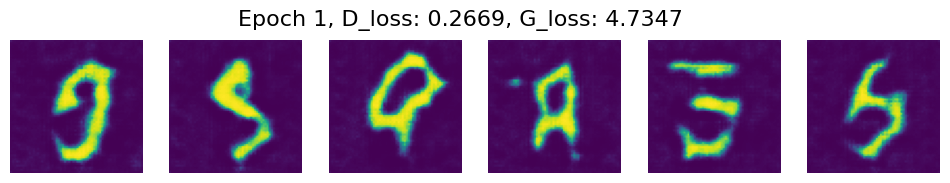

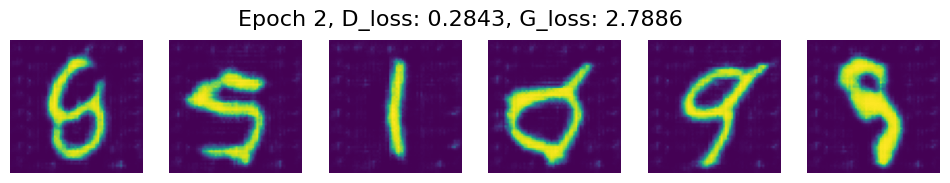

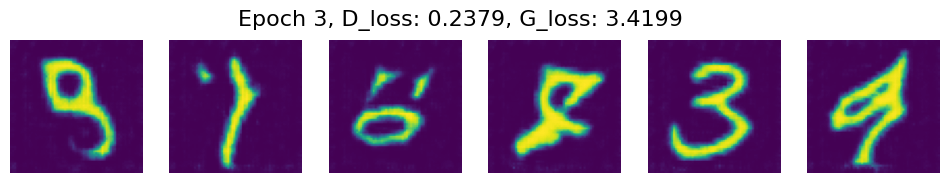

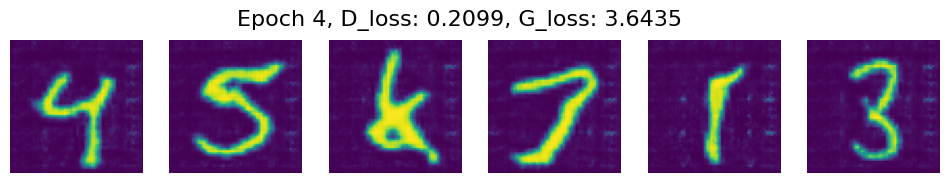

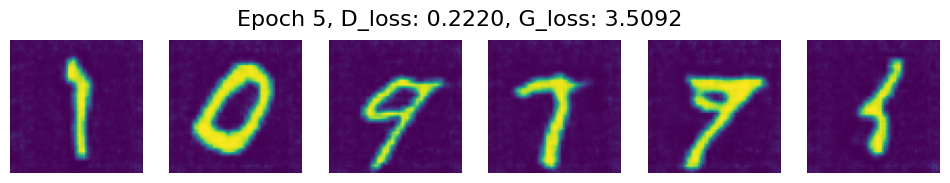

In [ ]:
discriminator = Discriminator(weight_init=True, in_channels=1).to(DEVICE)
generator = Generator(weight_init=True, in_channels=1).to(DEVICE)

optimizerD = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
train(generator, discriminator, trainloader, 5, optimizerD, optimizerG)

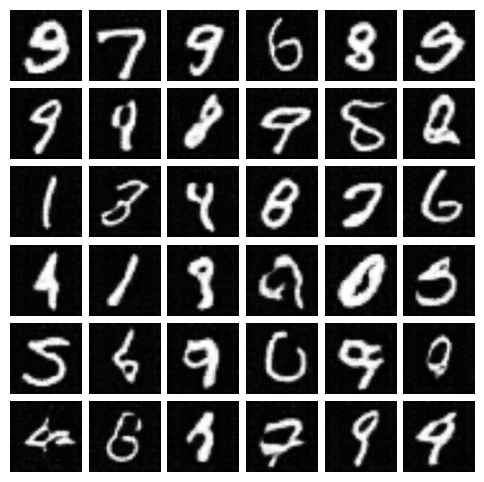

In [ ]:
noise = torch.randn(36, 100, 1, 1).to(DEVICE)
samples = generator(noise)
samples = ((samples + 1) * 0.5)
samples = samples.clamp(0, 1)
samples = samples.cpu().detach().numpy()
samples = np.transpose(samples, (0, 2, 3, 1))

grid_size = int(np.sqrt(36))
fig, axes = plt.subplots(grid_size, grid_size, figsize=(6, 6))
axes = axes.flatten()
for i in range(36):
    axes[i].imshow(samples[i], cmap='gray')
    axes[i].axis('off')
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

In [ ]:
torch.save(generator.state_dict(), '/content/drive/MyDrive/Deep unsupervised learning/GAN/dcgan_generator_mnist.pth')
torch.save(discriminator.state_dict(), '/content/drive/MyDrive/Deep unsupervised learning/GAN/dcgan_discriminator_mnist.pth')

## Cifar10

In [ ]:
dataset = torchvision.datasets.CIFAR10(root="./data", download=True,
                           transform=transforms.Compose([
                               transforms.Resize(64),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

dataloader = torch.utils.data.DataLoader(dataset, batch_size=128,
                                         shuffle=True, num_workers=2)

100%|██████████| 170498071/170498071 [00:02<00:00, 78859300.52it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [ ]:
class Discriminator(nn.Module):
    """
    Input: [B, 3, 64, 64]
    Output: [B, ]
    """
    def __init__(self, in_channels=1, weight_init=False):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, 1, 0, bias=False)
        )
        if weight_init:
            self.apply(self._initialize_weights)

    def forward(self, x):
        return self.net(x).view(-1, 1).squeeze(1)

    def _initialize_weights(self, m):
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
            nn.init.normal_(m.weight, 0.0, 0.02)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.normal_(m.weight, 1.0, 0.02)
            nn.init.constant_(m.bias, 0)

class Generator(nn.Module):
    """
    Input: [B, 100, 1, 1]
    Output: [B, 3, 64, 54]
    """
    def __init__(self, in_channels=3, weight_init=False):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            nn.ConvTranspose2d(100, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, in_channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )
        if weight_init:
            self.apply(self._initialize_weights)

    def forward(self, z):
        return self.net(z)

    def _initialize_weights(self, m):
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
            nn.init.normal_(m.weight, 0.0, 0.02)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.normal_(m.weight, 1.0, 0.02)
            nn.init.constant_(m.bias, 0)

In [ ]:
def train_epoch(discriminator, generator, train_loader, optimizer_disc, optimizer_gen):
    discriminator_loss = 0
    generator_loss = 0
    for i, (X, _) in enumerate(train_loader):
        X = X.to(DEVICE)
        batch_size = X.size(0)

        # Train the discriminator: real data
        optimizer_disc.zero_grad()
        D_real_loss = nn.BCEWithLogitsLoss()(discriminator(X), torch.ones((batch_size, )).to(DEVICE))
        D_real_loss.backward()

        # Train the discriminator: fake data
        X_fake = generator(torch.randn(batch_size, 100, 1, 1).to(DEVICE))
        D_fake_loss = nn.BCEWithLogitsLoss()(discriminator(X_fake), torch.zeros(batch_size, ).to(DEVICE))
        D_fake_loss.backward()

        # Train the discriminator
        D_loss = (D_real_loss + D_fake_loss) / 2
        optimizer_disc.step()

        # Train the generator
        optimizer_gen.zero_grad()
        X_fake = generator(torch.randn(batch_size, 100, 1, 1).to(DEVICE))
        G_loss = nn.BCEWithLogitsLoss()(discriminator(X_fake), torch.ones(batch_size, ).to(DEVICE))
        G_loss.backward()
        optimizer_gen.step()

        discriminator_loss += D_loss.item()
        generator_loss += G_loss.item()
    return discriminator_loss / len(train_loader), generator_loss / len(train_loader)

def plot_samples(generator, n_samples, device="cpu", title="Generated images"):
    samples = generator(torch.randn(n_samples, 100, 1, 1).to(device))
    samples = ((samples + 1) * 0.5)
    samples = samples.clamp(0, 1)
    samples = samples.cpu().detach().numpy()
    samples = np.transpose(samples, (0, 2, 3, 1))
    fig, ax = plt.subplots(1, 6, figsize=(12, 2))
    fig.suptitle(title, fontsize=16)
    for i in range(6):
        ax[i].imshow(samples[i])
        ax[i].axis('off')
    plt.show()

def train(generator, discriminator, train_loader, epochs, optimizerD, optimizerG):
    for epoch in range(epochs):
        disc_loss, gen_loss = train_epoch(discriminator, generator, train_loader, optimizerD, optimizerG)
        plot_samples(generator, 6, device=DEVICE, title=f"Epoch {epoch + 1}, D_loss: {disc_loss:.4f}, G_loss: {gen_loss:.4f}")


In [ ]:
fixed_noise = torch.randn(16, 100, 1, 1).to(DEVICE)
discriminator = Discriminator(weight_init=True).to(DEVICE)
generator = Generator(weight_init=True).to(DEVICE)

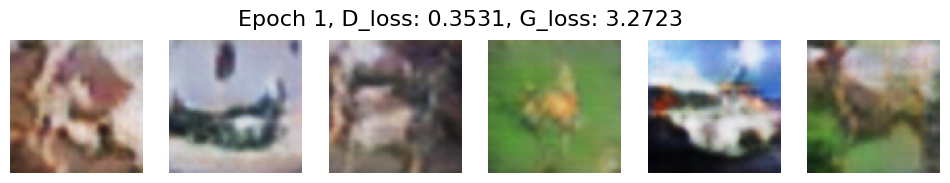

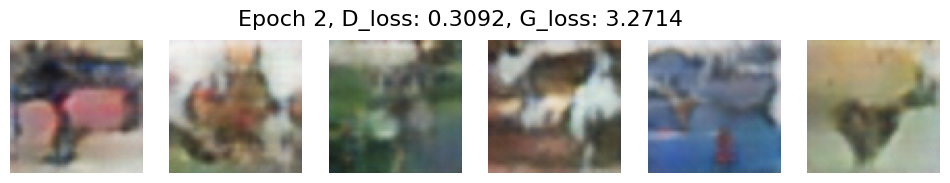

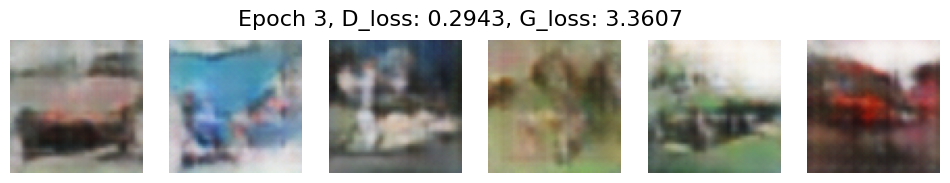

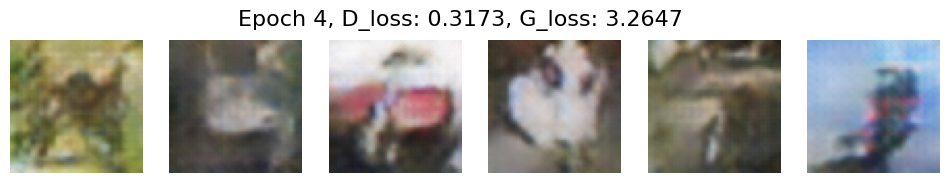

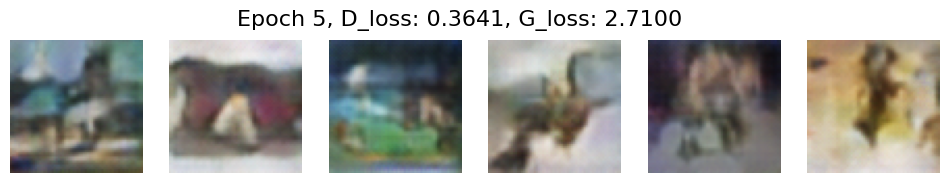

In [ ]:
optimizerD = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
train(generator, discriminator, dataloader, 5, optimizerD, optimizerG)

In [ ]:
generator = Generator(in_channels=3).to(DEVICE)
generator.load_state_dict(torch.load('/content/drive/MyDrive/Deep unsupervised learning/GAN/dcgan_generator_cifar10.pth'))
discriminator = Discriminator(in_channels=3).to(DEVICE)
discriminator.load_state_dict(torch.load('/content/drive/MyDrive/Deep unsupervised learning/GAN/dcgan_discriminator_cifar10.pth'))

<All keys matched successfully>

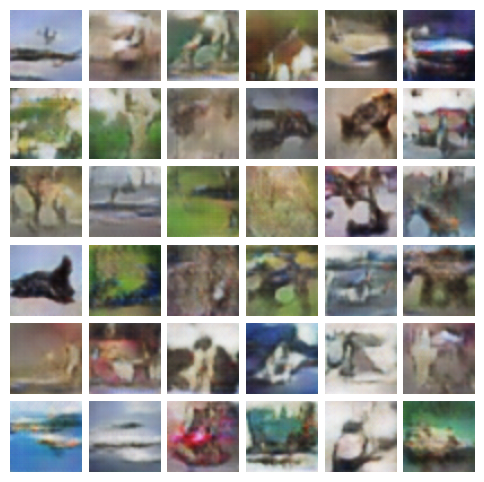

In [ ]:
noise = torch.randn(36, 100, 1, 1).to(DEVICE)
samples = generator(noise)
samples = ((samples + 1) * 0.5)
samples = samples.clamp(0, 1)
samples = samples.cpu().detach().numpy()
samples = np.transpose(samples, (0, 2, 3, 1))

grid_size = int(np.sqrt(36))
fig, axes = plt.subplots(grid_size, grid_size, figsize=(6, 6))
axes = axes.flatten()
for i in range(36):
    axes[i].imshow(samples[i])
    axes[i].axis('off')
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

In [ ]:
torch.save(generator.state_dict(), '/content/drive/MyDrive/Deep unsupervised learning/GAN/dcgan_generator_cifar10.pth')
torch.save(discriminator.state_dict(), '/content/drive/MyDrive/Deep unsupervised learning/GAN/dcgan_discriminator_cifar10.pth')